# Computing ensemble percentiles from multiple netcdf files using cascade graph framework

In this notebook we process multiple source files, each representing a ensemble forecast. Within each file we have 3-dimensional data in (time, y, x). 

We want to combine those the files along a new dimension 'member' and perform a quantile computation. We split the computation per time step to simulate larger data where loading everything into memory is not possible.

We build the same workflow twice and compare the results from a direct computation using xarray/dask api.

In [1]:
import os
import logging as log

import numpy as np
import xarray as xr
import pandas as pd

from cascade import Cascade
from cascade.fluent import from_source, Payload, Node

In [2]:
def create_test_data_files(n_members=3, n_leadtimes=7, shape=(4500, 5000)):
    """Create a test dataset with random data."""
    import tempfile
    data = np.random.rand(n_members, n_leadtimes, *shape) * 100
    coords = {
        'member': np.arange(n_members),
        'leadtime': pd.date_range("20240419T1200", freq='h', periods=n_leadtimes),
        'y': np.linspace(-90, 90, shape[0]),
        'x': np.linspace(-180, 180, shape[1]),
    }
    ds = xr.Dataset(
        data_vars={
            'rainfall': (('member', 'leadtime', 'y', 'x'), data),
        },
        coords=coords,
        attrs={'source': 'test', 'description': 'random data'}
    )
    tempdir = tempfile.mkdtemp()
    outpaths, datasets = [], []
    for mem in range(n_members):
        outpaths += [os.path.join(tempdir, f'rainfall_ENS{mem:02d}.nc')]
        datasets += [ds.sel(member=mem).drop_vars('member')]
    xr.save_mfdataset(datasets, outpaths, compute=True)
    return outpaths

def write_netcdf(
        nparray:np.ndarray, filename:str,
        dims:list, coords:np.ndarray,
        varname:str = 'rainfall', attrs:dict = {}, **kwargs
    ):

    xr.DataArray(
        nparray,
        dims=dims,
        coords=coords,
        name=varname,
        attrs=attrs,
    ).to_netcdf(filename, **kwargs)

def compute_percentile(da: xr.DataArray, q: float | np.ndarray, **kwargs):
    log.info(f'input array {da}')
    return da.quantile(q, **kwargs)


## Test parameters

Here we define the size of our test. We can multiply this for even larger problems or just replace the `file_list` for an actual file list and test with your own data.

In [3]:
# replace this by a list of actual files and test on your own datasets
members=3
n_steps=7
OUTFILE='rainfall_perc80.nc'
quantiles=0.8
file_list = create_test_data_files(members, n_steps)

## Building the Graph with Cascade

### Defining our data sources

In [4]:
payloads = []
for fname in file_list:
    payloads += [
        Payload(
            xr.open_dataarray,
            [fname],
            dict(mask_and_scale=False)
        )
    ]
inputs = (
    from_source(
        payloads,
        dims=['member'],
    )
    # we split the file over the forecast time steps
    .expand(
        dim='step', dim_size=n_steps, axis=0, new_axis=0,
    )
)


### Putting the members nodes together and doing the computation

In [5]:

prev_node = None
for step in range(n_steps):
    # we first select the nodes from different ensemble members and same time step
    step_nodes = inputs.select({'step': step}, drop=False)
    # then we stack them along a member dimension
    res = (
        step_nodes.stack(
            dim='member',
            keep_dim=False,
            axis=0,
            backend_kwargs=dict(dim='member'),
        )
        # here we define the actual computation
        .map(
            Payload(
                compute_percentile,
                kwargs=dict(q=quantiles, dim='member', skipna=False)),
        )
    )
    if prev_node is None:
        prev_node = res
    else:
        prev_node = prev_node.join(
            other_action=res,
            dim='step',
        )


### Merging final results and defining output in single file

In [6]:

# output template
tmplt_da = (
    xr.open_dataset(file_list[0], chunks='auto')['rainfall']
)
coords = tmplt_da.coords
dims = tmplt_da.dims
attrs = tmplt_da.attrs

actions = (
    prev_node
    .stack(
        dim='step',
        keep_dim=False,
        axis=0,
        backend_kwargs=dict(dim='leadtime'),
    )
    .map(
        Payload(
            write_netcdf,
            [Node.input_name(0)],
            kwargs=dict(
                dims=dims,
                attrs=attrs,
                coords=coords,
                varname='rainfall',
                filename=OUTFILE,
                mode='w', engine='netcdf4'
            ),
        )
    )
)


### The final Graph

In [7]:

cascade = Cascade.from_actions([actions])
cascade.visualise("cascadegraph_percentile.html", cdn_resources='in_line')

cascadegraph_percentile.html


In [8]:
if os.path.exists(OUTFILE):
    os.remove(OUTFILE)
cascade.execute(memory_limit="4GB", n_workers=2, threads_per_worker=1)

{'address': 'tcp://127.0.0.1:56569',
 'id': 'Scheduler-1d085872-82b0-4999-9240-5147ca6ea890',
 'services': {'dashboard': 8787},
 'started': 1713551555.970262,
 'type': 'Scheduler',
 'workers': {'tcp://127.0.0.1:56576': {'host': '127.0.0.1',
                                       'id': 1,
                                       'local_directory': '/var/folders/qd/t0yk3dps17g7b7br8cpnxdnc0000gn/T/dask-scratch-space/worker-jj48bbq7',
                                       'memory_limit': 4000000000,
                                       'name': 1,
                                       'nanny': 'tcp://127.0.0.1:56573',
                                       'nthreads': 1,
                                       'resources': {},
                                       'services': {'dashboard': 56579},
                                       'status': 'init',
                                       'type': 'Worker'},
             'tcp://127.0.0.1:56577': {'host': '127.0.0.1',
                  

2024-04-19 19:32:46,286 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 3.10 GiB -- Worker memory limit: 3.73 GiB
2024-04-19 19:32:46,714 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.14 GiB -- Worker memory limit: 3.73 GiB


All tasks completed successfully.


{'write_netcdf:b380b1f588219f0ecc6bdc76e8ddef7feefdee69efc139c15d1ebdc2056d2541': None}

## Direct implementation with native xarray/dask

In [9]:
ds = xr.open_mfdataset(
    file_list,
    concat_dim='member',
    combine='nested',
    mask_and_scale=False,
    chunks={'leadtime': 1},
)
ds = ds.chunk({'member': -1})

res = list()
for step in range(7):
    da = ds['rainfall'].isel(leadtime=step).transpose('member', 'y', 'x')
    perc = da.quantile(q=.80, dim='member', skipna=False)
    res.append(perc)
ref = (
    xr.combine_nested(res, concat_dim='leadtime')
    .assign_coords({'leadtime':coords['leadtime']})
    .drop_vars(['quantile'])
)
ref.to_netcdf('dask_results.nc')
ref

<xarray.DataArray 'rainfall' (leadtime: 7, y: 4500, x: 5000)> Size: 1GB
dask.array<concatenate, shape=(7, 4500, 5000), dtype=float64, chunksize=(1, 4500, 5000), chunktype=numpy.ndarray>
Coordinates:
  * y         (y) float64 36kB -90.0 -89.96 -89.92 -89.88 ... 89.92 89.96 90.0
  * x         (x) float64 40kB -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * leadtime  (leadtime) datetime64[ns] 56B 2024-04-19T12:00:00 ... 2024-04-1...

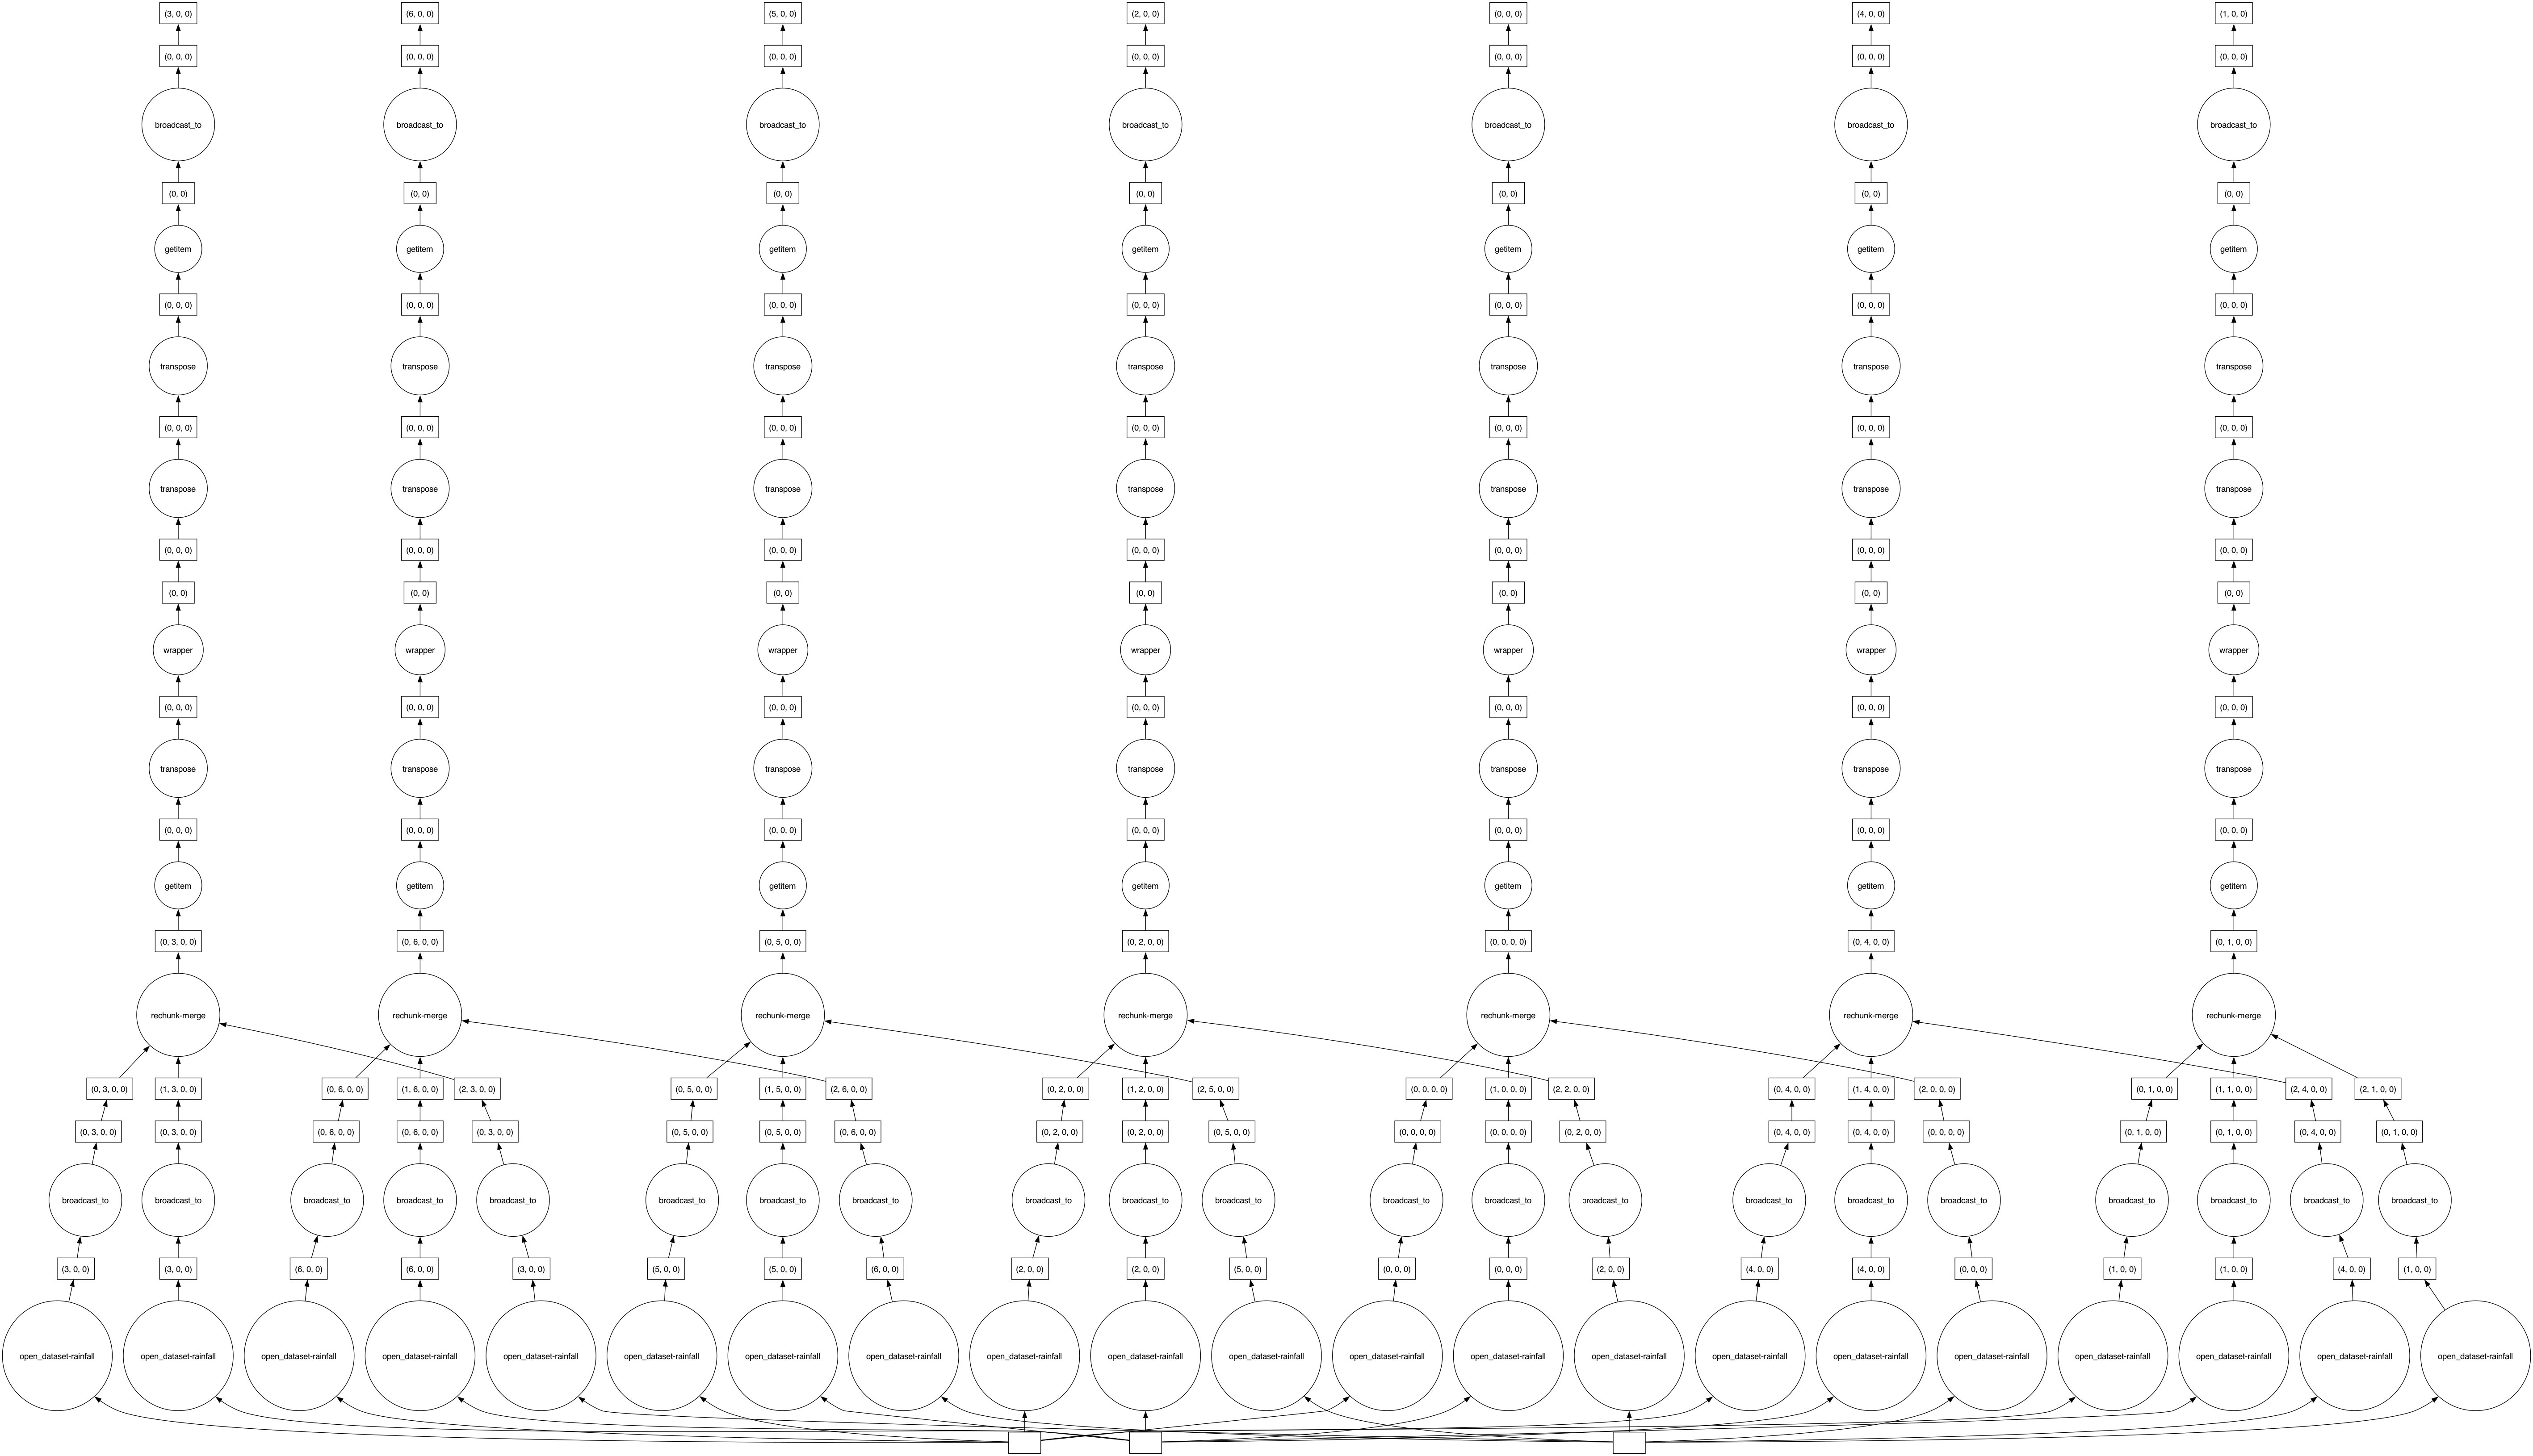

In [10]:
ref.data.visualize('daskgraph_percentile.png')  # you may need to install graphviz to make this work

In [11]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    ref.compute()

[########################################] | 100% Completed | 9.43 sms


In [12]:
res = xr.open_dataset(OUTFILE, mask_and_scale=False)
res

<xarray.Dataset> Size: 1GB
Dimensions:   (leadtime: 7, y: 4500, x: 5000)
Coordinates:
  * leadtime  (leadtime) datetime64[ns] 56B 2024-04-19T12:00:00 ... 2024-04-1...
  * y         (y) float64 36kB -90.0 -89.96 -89.92 -89.88 ... 89.92 89.96 90.0
  * x         (x) float64 40kB -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Data variables:
    rainfall  (leadtime, y, x) float64 1GB ...

In [13]:
ref = xr.open_dataset('dask_results.nc', mask_and_scale=False)

In [14]:
ref

<xarray.Dataset> Size: 1GB
Dimensions:   (y: 4500, x: 5000, leadtime: 7)
Coordinates:
  * y         (y) float64 36kB -90.0 -89.96 -89.92 -89.88 ... 89.92 89.96 90.0
  * x         (x) float64 40kB -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * leadtime  (leadtime) datetime64[ns] 56B 2024-04-19T12:00:00 ... 2024-04-1...
Data variables:
    rainfall  (leadtime, y, x) float64 1GB ...

In [15]:
res

<xarray.Dataset> Size: 1GB
Dimensions:   (leadtime: 7, y: 4500, x: 5000)
Coordinates:
  * leadtime  (leadtime) datetime64[ns] 56B 2024-04-19T12:00:00 ... 2024-04-1...
  * y         (y) float64 36kB -90.0 -89.96 -89.92 -89.88 ... 89.92 89.96 90.0
  * x         (x) float64 40kB -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Data variables:
    rainfall  (leadtime, y, x) float64 1GB ...

In [17]:
xr.testing.assert_allclose(ref, res)